In [54]:
# Importing libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ssl
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, pipeline
import torch

In [16]:
# Load the combined metadata CSV file
current_dir = os.getcwd()
combined_file = os.path.join(current_dir, '..', 'data', 'metadata','metadata_sampled_ai_and_random.csv') # change this name to get a different cut
df = pd.read_csv(combined_file)

# Ensure consistent column names
df.columns = [col.strip() for col in df.columns]

# Get df info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 45 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   dc.contributor.advisor      115 non-null    object 
 1   dc.contributor.author       400 non-null    object 
 2   dc.date.accessioned         400 non-null    object 
 3   dc.date.available           400 non-null    object 
 4   dc.date.issued              400 non-null    object 
 5   dc.identifier.uri           400 non-null    object 
 6   dc.relation.ispartofseries  377 non-null    object 
 7   dc.title                    400 non-null    object 
 8   dc.description.abstract     388 non-null    object 
 9   dc.identifier.other         282 non-null    object 
 10  dc.format.extent            362 non-null    object 
 11  dc.format.mimetype          262 non-null    object 
 12  dc.language.iso             268 non-null    object 
 13  dc.subject                  297 non

In [15]:
# Function to create a dataframe with subjects

def create_subjects_dataframe(df):
    # Extract research paper ID, year, abstract, and subjects
    # Abstract can be used in the future for text analysis
    subjects_df = df[['research_paper_id', 'year','dc.description.abstract','dc.subject']].dropna()

    # Filter for rows where "dc.subject" begins with "AI"
    subjects_df = subjects_df[subjects_df['dc.subject'].str.contains('AI', case=True)]
    subjects_df = subjects_df.assign(subject=subjects_df['dc.subject'].str.split(';')).explode('subject')
    subjects_df['subject'] = subjects_df['subject'].str.strip()

    # Assign unique IDs to each subject
    subjects_df['subject_id'] = subjects_df['subject'].factorize()[0] + 1
    return subjects_df[['research_paper_id', 'year','dc.description.abstract','subject_id', 'subject']]

In [17]:
# Savign the subjects dataframe (created using simple filtering approach)
subjects_df = create_subjects_dataframe(df)
subjects_df.to_csv(os.path.join(current_dir, '..', 'data', 'subjects','subjects_simple.csv'), index=False)
print("Subjects DataFrame created and saved.")

Subjects DataFrame created and saved.


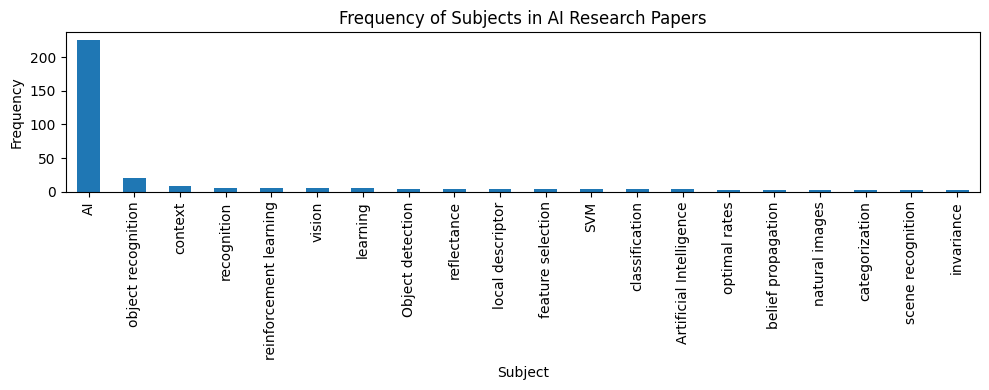

In [25]:
# Simple method to explore research topics in AI: check frequency of subjects
# Count the frequency of each subject
subject_counts = subjects_df['subject'].value_counts()

# Plot the frequency of the top 20 subjects
plt.figure(figsize=(10, 4))
subject_counts.head(20).plot(kind='bar')
plt.title('Frequency of Subjects in AI Research Papers')
plt.ylabel('Frequency')
plt.xlabel('Subject')
plt.tight_layout()

While this gives some idea of topics, a better idea might be to find topics in the paper abstracts. To do that, we will follow an unsupervised learning approach called **Latent Dirichlet Allocation (LDA)** which helps in finding common topics in text.

Hopefully, we can use some of those topics as labels and use a pre-trained transformer model with zero-shot classification to assign topics to our research papers.

In [38]:
# First, we define a corpus of stop words
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
from nltk.corpus import stopwords
nltk.download('stopwords')

# Load the stopwords
nltk_stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/eshan23/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
# For this part, we will work with the original df of 400 papers defined as "df" above

# Combine title and abstract into a single text column and handle NaNs
df['text'] = df['dc.title'].fillna('').str.lower() + " " + df['dc.description.abstract'].fillna('').str.lower()

# Vectorize the text data
vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
X = vectorizer.fit_transform(df['text'])

In [52]:
# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Sum the TF-IDF values for each feature
tfidf_sum = X.sum(axis=0).A1

# Create a DataFrame with feature names and their corresponding TF-IDF scores
tfidf_scores = pd.DataFrame({'feature': feature_names, 'tfidf': tfidf_sum})

# Sort the DataFrame by TF-IDF scores in descending order
tfidf_scores = tfidf_scores.sort_values(by='tfidf', ascending=False)

# Print the top 50 keywords
print(tfidf_scores.head(50))

        feature      tfidf
0     algorithm  24.439690
5         based  23.180584
96        using  22.983043
46        model  22.423354
35  information  22.392722
40     learning  21.512886
14         data  21.277446
57       object  20.729245
32        image  19.681801
61        paper  18.584700
63  performance  17.985713
87      systems  17.083376
73  recognition  17.012580
4      approach  16.646011
64      present  16.346239
56       number  15.807633
27     features  15.719035
75      results  15.690196
2      analysis  15.682332
50      network  15.621017
47       models  15.393193
65      problem  15.371746
79          set  14.933173
52          new  14.912364
92         time  14.840261
33       images  14.830800
95         used  14.708236
16       design  14.641113
94          use  14.565853
28    framework  14.270209
1    algorithms  14.017442
18    different  13.698994
97       visual  13.227304
45      methods  13.033977
51     networks  12.398314
83        space  12.011302
6

In [49]:
# Vectorize the text data
vectorizer_lda = CountVectorizer(stop_words='english')
text_data = vectorizer_lda.fit_transform(df['text'])

# Train LDA model
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(text_data)

# Extract topics
topics = []
for idx, topic in enumerate(lda.components_):
    topics.append([vectorizer_lda.get_feature_names_out()[i] for i in topic.argsort()[-10:]])

# Print the topics
for idx, topic in enumerate(topics):
    print(f"Topic {idx}: {topic}")

Topic 0: ['different', 'simple', 'visual', 'features', 'cortex', 'based', 'performance', 'recognition', 'model', 'object']
Topic 1: ['set', 'learning', 'tuning', 'using', 'data', 'algorithm', 'patches', 'based', 'model', 'present']
Topic 2: ['paper', 'use', 'image', 'classification', 'face', 'knowledge', 'based', 'features', 'using', 'information']
Topic 3: ['distributed', 'model', 'wireless', 'using', 'framework', 'data', 'networks', 'learning', 'nodes', 'network']
Topic 4: ['systems', 'state', 'level', 'recognition', 'structure', 'using', 'data', 'based', 'model', 'visual']
Topic 5: ['image', 'approach', 'problem', 'based', 'methods', 'using', 'images', 'learning', 'method', 'algorithm']
Topic 6: ['log', 'program', 'cost', 'data', 'model', 'chip', 'problem', 'memory', 'algorithm', 'cache']
Topic 7: ['data', 'type', 'image', 'set', 'learning', 'method', 'framework', 'using', 'information', 'methods']
Topic 8: ['information', 'global', 'reflectance', 'properties', 'scene', 'based', 'lo

In [50]:
# Function to get the top n-grams
def get_top_n_grams(corpus, n=None, ngram_range=(1, 1)):
    vec = CountVectorizer(stop_words=nltk_stop_words, ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

In [51]:
# Extract unigrams
unigrams = get_top_n_grams(df['text'], n=20, ngram_range=(1, 1))
print("Top 20 Unigrams:", unigrams)

# Extract bigrams
bigrams = get_top_n_grams(df['text'], n=20, ngram_range=(2, 2))
print("Top 20 Bigrams:", bigrams)

# Extract trigrams
trigrams = get_top_n_grams(df['text'], n=20, ngram_range=(3, 3))
print("Top 20 Trigrams:", trigrams)


Top 20 Unigrams: [('system', 266), ('based', 240), ('using', 227), ('model', 215), ('image', 180), ('object', 175), ('information', 175), ('algorithm', 175), ('data', 167), ('learning', 160), ('recognition', 146), ('approach', 145), ('show', 142), ('performance', 137), ('present', 133), ('results', 132), ('paper', 131), ('features', 126), ('also', 124), ('images', 122)]
Top 20 Bigrams: [('object recognition', 52), ('real world', 29), ('real time', 26), ('low level', 26), ('reinforcement learning', 21), ('object detection', 18), ('high level', 18), ('et al', 17), ('visual cortex', 16), ('type omega', 16), ('visual system', 16), ('ad hoc', 16), ('based approach', 15), ('paper presents', 15), ('recognition cortex', 15), ('also show', 14), ('data structures', 14), ('model based', 14), ('surface reflectance', 13), ('type alpha', 13)]
Top 20 Trigrams: [('object recognition cortex', 13), ('type omega dpls', 11), ('model object recognition', 11), ('real world illumination', 10), ('non rigid re

**Observations:**

1. Analysis of tokens in research paper abstracts gives us an idea of two things: the kind of modelling terminology (e.g. reinforcement learning) used and broad problem space (e.g. object recognition) explored in our sampled research papers. 

2. Across the three approaches: normalized count based on Tf-Idf, topic modelling using LDA and n-grams based on counts, vision based applications jump out. There is one token that covers _language_ and none that covers speech. 

3. Based on this analysis, and a manual scan of paper abstracts and subjects, we can use the following labels: 
    - Object Recognition/Detection
    - Image Classification
    - Face Detection
    - Language Models
    - Speech/Audio Recognition
    - Robotics
    - High Performance Computing
    - Privacy / Ethics

4. We can use these labels with a transformer model that can classify research papers based on zero-shot approach

In [55]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize text
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

# Convert to dataset format
dataset = df[['text']].apply(tokenize_function, axis=1)

/Users/eshan23/Library/Caches/pypoetry/virtualenvs/wang-ml-ZjUsplGQ-py3.11/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [58]:
# Initialize zero-shot classifier
classifier = pipeline('zero-shot-classification', model='facebook/bart-large-mnli')

# Define candidate labels
candidate_labels = ['object recognition/detection', 'image classification', 'face detection',\
    'language models', 'speech/audio recognition', 'robotics', 'high performance computing', 'privacy/ethics']

# Perform zero-shot classification
df['predicted_topic'] = df['text'].apply(lambda x: classifier(x, candidate_labels)['labels'][0])

# Display the results
print(df[['text', 'predicted_topic']])

                                                  text  \
0    a trainable system for object detection in ima...   
1    a note on the generalization performance of ke...   
2    feature point detection and curve approximatio...   
3    design and control of an anthropomorphic robot...   
4    predicate dispatching in the common lisp objec...   
..                                                 ...   
395  learning complex cell invariance from natural ...   
396  a frequency analysis of monte-carlo and other ...   
397  aeolus reference manual this document describe...   
398  execution model enforcement via program shephe...   
399  motion coordination using virtual nodes we des...   

                  predicted_topic  
0    object recognition/detection  
1      high performance computing  
2    object recognition/detection  
3                        robotics  
4                 language models  
..                            ...  
395          image classification  
396            

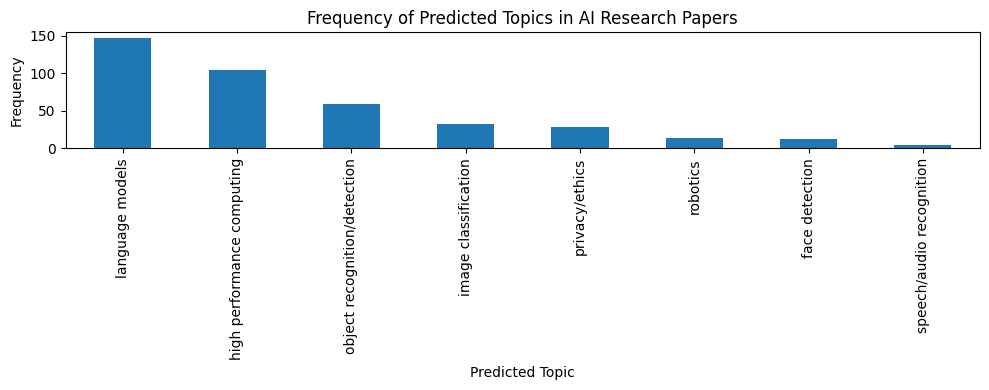

In [59]:
# Examine the distribution of predicted topics
topic_counts = df['predicted_topic'].value_counts()

# Plot the frequency of the predicted topics
plt.figure(figsize=(10, 4))
topic_counts.plot(kind='bar')
plt.title('Frequency of Predicted Topics in AI Research Papers')
plt.ylabel('Frequency')
plt.xlabel('Predicted Topic')
plt.tight_layout()

In [60]:
# Save the updated metadata file
df.to_csv(os.path.join(current_dir, '..', 'data', 'subjects','subjects_classification_using_bert.csv'), index=False)

Manual examination indicates that quite a few results in **object detection**, **image classification**, **facial recognition** are accurate; however, this doesn't seem to be the case for **language models**: the most frequently occuring bucket. A lot of the _abstract descriptions_ classified as **language models** cover mathematical concepts and modelling related information. 

After this exploratory labelling exercise, a good next step would be to manually label some papers, and change labels (for example use parallel computing instead of or in addition to high-performance computing). We could also set up the problem and code such that probabilities are included in the output instead of one label that is most likely.